# Laptop Price Prediction — Model Training
This notebook trains and evaluates baseline models to predict `Price_euros`.
We will:
- Load the cleaned dataset.
- Split into train/test sets.
- Optionally scale numeric features.
- Train a baseline Linear Regression.
- Train a Random Forest regressor.
- Evaluate with MAE, RMSE and R².
- Visualize predictions and save the best model (for later Streamlit use).

### Step 0 - Imports Necessary Libraries
Import necessary libraries (Imports used throughout the notebook).

In [1]:
# Step 0 - imports
import os
import joblib
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split as split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

sns.set(style="whitegrid")
RANDOM_STATE = 1  
# We will use random_state=1 and test_size=0.2 (20%) as our group's values.

# Ensure output folders exist
os.makedirs("../models", exist_ok=True)
os.makedirs("../reports/figures", exist_ok=True)

### Step 1 - Load Dataset
Load the processed CSV saved from data cleaning.

In [2]:
data = pd.read_csv("../data/processed/laptops_cleanned.csv")
print("Shape:", data.shape)
display(data.head())
print("\nMissing values per column:\n", data.isnull().sum())

Shape: (1303, 17)


,Company,TypeName,Inches,Ram,Gpu,OpSys,Weight,Price_euros,SSD,HDD,Hybrid,Flash_Storage,Touchscreen,X_resolution,Y_resolution,Cpu_brand,Cpu_speed
0,Apple,Ultrabook,13.3,8,Intel Iris Plus Graphics 640,macOS,1.37,1339.69,128,0,0,0,0,2560,1600,Intel Core i5,2.3
1,Apple,Ultrabook,13.3,8,Intel HD Graphics 6000,macOS,1.34,898.94,0,0,0,128,0,1440,900,Intel Core i5,1.8
2,HP,Notebook,15.6,8,Intel HD Graphics 620,No OS,1.86,575.00,256,0,0,0,0,1920,1080,Intel Core i5 7200U,2.5
3,Apple,Ultrabook,15.4,16,AMD Radeon Pro 455,macOS,1.83,2537.45,512,0,0,0,0,2880,1800,Intel Core i7,2.7
4,Apple,Ultrabook,13.3,8,Intel Iris Plus Graphics 650,macOS,1.37,1803.60,256,0,0,0,0,2560,1600,Intel Core i5,3.1



Missing values per column:
 Company          0
TypeName         0
Inches           0
Ram              0
Gpu              0
OpSys            0
Weight           0
Price_euros      0
SSD              0
HDD              0
Hybrid           0
Flash_Storage    0
Touchscreen      0
X_resolution     0
Y_resolution     0
Cpu_brand        0
Cpu_speed        0
dtype: int64


### Step 2 - Definition
- Define features (X) and target (y).
- Separate predictors and target variable.

In [3]:
if "Price_euros" not in data.columns:
    raise KeyError("Target column 'Price_euros' not found in dataset.")

X = data.drop("Price_euros", axis=1)
y = data["Price_euros"]

print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (1303, 16)
y shape: (1303,)


### Step 3 — Train / test split
- Reserve 20% for test. 
- Keep random_state for reproducibility.

In [4]:
X_train, X_test, y_train, y_test = split(X, y,test_size=0.2, random_state=RANDOM_STATE)
print("X_train:", X_train.shape, '\n' "X_test:", X_test.shape)

X_train: (1042, 16) 
X_test: (261, 16)


### Step 4 — (Optional) Scale numeric features
- Linear models benefit from scaling; tree-based models do not require it. 
- We'll scale and save the scaler so we can use the same transforms at inference.

- Why this matters :
    - Many ML algorithms assume features are on a similar scale.
    - Avoids data leakage by fitting only on the training data.

In [5]:
# (optional but recommended for linear models)

# Detect numeric columns (should already be numeric after cleaning)
numeric_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()
print("Numeric cols to scale:", numeric_cols)

scaler = StandardScaler()
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

# Fit scaler only on training numeric columns
X_train_scaled[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
X_test_scaled[numeric_cols] = scaler.transform(X_test[numeric_cols])

# Save scaler for later (inference)
joblib.dump(scaler, "../models/scaler.pkl")
print("Scaler saved to ../models/scaler.pkl")

Numeric cols to scale: ['Inches', 'Ram', 'Weight', 'SSD', 'HDD', 'Hybrid', 'Flash_Storage', 'Touchscreen', 'X_resolution', 'Y_resolution', 'Cpu_speed']
Scaler saved to ../models/scaler.pkl


### Step 5 — Baseline model: Linear Regression
- Train a linear regression on the scaled features.

⚠️ Fix: Encode categorical features before training  
(Linear Regression cannot handle string columns like "Dell", "Windows 10", etc.  
We’ll use OneHotEncoding to turn them into numeric dummy variables.)

In [6]:
# Detect categorical columns
cat_cols = X_train.select_dtypes(include=["object"]).columns.tolist()
print("Categorical columns:", cat_cols)

# OneHotEncode categorical columns
X_train_encoded = pd.get_dummies(X_train, columns=cat_cols, drop_first=True)
X_test_encoded = pd.get_dummies(X_test, columns=cat_cols, drop_first=True)

# Align columns (train/test must have same columns after encoding)
X_train_encoded, X_test_encoded = X_train_encoded.align(X_test_encoded, join="left", axis=1, fill_value=0)

print("X_train_encoded shape:", X_train_encoded.shape)
print("X_test_encoded shape:", X_test_encoded.shape)

# Scale numeric columns for linear regression
scaler = StandardScaler()
X_train_scaled = X_train_encoded.copy()
X_test_scaled = X_test_encoded.copy()

numeric_cols = X_train_encoded.select_dtypes(include=[np.number]).columns.tolist()
X_train_scaled[numeric_cols] = scaler.fit_transform(X_train_encoded[numeric_cols])
X_test_scaled[numeric_cols] = scaler.transform(X_test_encoded[numeric_cols])

Categorical columns: ['Company', 'TypeName', 'Gpu', 'OpSys', 'Cpu_brand']
X_train_encoded shape: (1042, 218)
X_test_encoded shape: (261, 218)


In [7]:
# Step 5 - Train Linear Regression (on scaled data)
lin_reg = LinearRegression()
lin_reg.fit(X_train_scaled, y_train)

# Display the model's coefficient and intercept 
print(f'Model Coeffient: {lin_reg.coef_}')
print(f'Model Intercept: {lin_reg.intercept_}')

# Make predictions on the training data 
y_train_pred_lr = lin_reg.predict(X_train_scaled)

print(f'Prediction on training set: {y_train_pred_lr[:10]}')
print(f'Actual Training data: {y_train[:10].values}')

# Make predictions on the test data 
y_pred_lr = lin_reg.predict(X_test_scaled)

print(f'Prediction Test set: {y_pred_lr[:10]}')
print(f'Actual Test data: {y_test[:10].values}')

Model Coeffient: [-1.08708111e+01  1.30503579e+02 -5.98643778e+00  1.43293182e+02
  2.42737078e+01  1.84938491e+01  3.31617558e+01 -2.12035126e+01
 -3.03931836e+00  7.47113679e+01  5.76631461e+01  1.93533094e+02
  2.36825230e+01 -1.81830260e+02  9.53957206e+01 -5.43298348e+00
  2.13630516e+02  1.31119441e+02 -6.39257124e+01  6.26387547e+02
  1.12839663e+02  1.10196218e+02 -8.07315462e+01  1.79531257e+02
  6.80359344e+02  2.00135252e+02  2.73127129e+02 -1.02676413e+02
  1.84094991e+02 -3.54984447e+02 -1.55349934e+02 -2.26504883e+02
  3.81317001e+01 -1.94218618e+02  2.35089517e+02  3.03520936e+02
  1.44677209e+03 -1.80810360e+02 -2.78000772e+02 -2.81880050e+02
 -1.62007361e+02  1.40820260e+02  1.39926778e+02  4.37729678e+02
 -4.49613330e+01 -1.12980849e+02 -7.78799915e+01 -1.97324600e+02
 -2.37046427e+02 -1.97415780e+01 -3.01923956e+02 -3.01190316e+02
 -7.81657040e+01 -9.50006978e+01 -1.75838752e+02 -1.55777041e+02
 -5.96242223e+01 -1.76852626e+02 -1.87858595e+02 -9.07566131e+01
  1.4140

In [23]:
print(lin_reg)

LinearRegression()


### Step 6 — Evaluate Linear Regression
(Print MAE, RMSE and R²)

In [8]:
# Step 6 - Evaluate linear regression
mae_lr = mean_absolute_error(y_test, y_pred_lr)
mse_lr = mean_squared_error(y_test, y_pred_lr)
rmse_lr = np.sqrt(mean_squared_error(y_test, y_pred_lr))   # <- replace squared=False with np.sqrt(...)
r2_lr = r2_score(y_test, y_pred_lr)

print("Linear Regression Performance:")
print(f"MAE: {mae_lr:.3f}")
print(f"MSE: {mse_lr:.3f}")
print(f"RMSE: {rmse_lr:.3f}")
print(f"R²: {r2_lr:.3f}")

Linear Regression Performance:
MAE: 193.112
MSE: 94196.831
RMSE: 306.915
R²: 0.808


### Step 7 — Stronger model: Random Forest Regressor
- Train a Random Forest. 
- Trees don't require scaling; we'll use the unscaled features.

In [16]:
# Step 7 - Train Random Forest (use unscaled data)
rf = RandomForestRegressor(n_estimators=100, random_state=RANDOM_STATE, n_jobs=-1)
rf.fit(X_train_encoded, y_train)

y_train_pred_rf = rf.predict(X_train_scaled)

print(f'Prediction on training set:\n {y_train_pred_rf[:10]}\n')
print(f'Actual Training data:\n {y_train[:10].values}\n')


y_pred_rf = rf.predict(X_test_encoded)

print(f'Prediction Test set:\n {y_pred_rf[:10]}\n')
print(f'Actual Test data:\n {y_test[:10].values}\n')

Prediction on training set:
 [516.2751     645.8089     317.38735    631.62527667 510.6421
 511.1686     348.88       440.94223333 788.59526667 507.4166    ]

Actual Training data:
 [1775.  665. 1579. 2799. 1099. 1082. 2349. 5499. 3975.  989.]

Prediction Test set:
 [ 429.3104      904.7185     1385.103      1027.5448     2150.1064
  892.58643333 1295.22263333  787.03173333  288.377      1321.3456    ]

Actual Test data:
 [ 450.    729.   1079.   1049.26 1899.   1018.    752.    649.    289.
 1962.99]



### Step 8 — Evaluate Random Forest
- Compare metrics with linear model.

In [10]:
# Step 8 - Evaluate Random Forest
mae_rf  = mean_absolute_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
r2_rf   = r2_score(y_test, y_pred_rf)

print("Random Forest Performance:")
print(f"MAE: {mae_rf:.2f}")
print(f"RMSE: {rmse_rf:.2f}")
print(f"R²: {r2_rf:.4f}")

Random Forest Performance:
MAE: 160.62
RMSE: 260.61
R²: 0.8619


### Step 9: Compare Models
- Collect metrics into a DataFrame for easy comparison.

In [11]:
results = pd.DataFrame({
    "model": ["LinearRegression", "RandomForest"],
    "MAE": [mae_lr, mae_rf],
    "RMSE": [rmse_lr, rmse_rf],
    "R²": [r2_lr, r2_rf]
})
display(results.sort_values("R²", ascending=False))
# Save metrics
results.to_csv("../reports/model_results_summary.csv", index=False)
print("Saved metrics to ../reports/model_results_summary.csv")

,model,MAE,RMSE,R²
1,RandomForest,160.623555,260.614212,0.861885
0,LinearRegression,193.112201,306.915022,0.808451


Saved metrics to ../reports/model_results_summary.csv


### Step 10 — Visualize predictions vs actual
- Plot actual vs predicted and a 45° line to see fit.

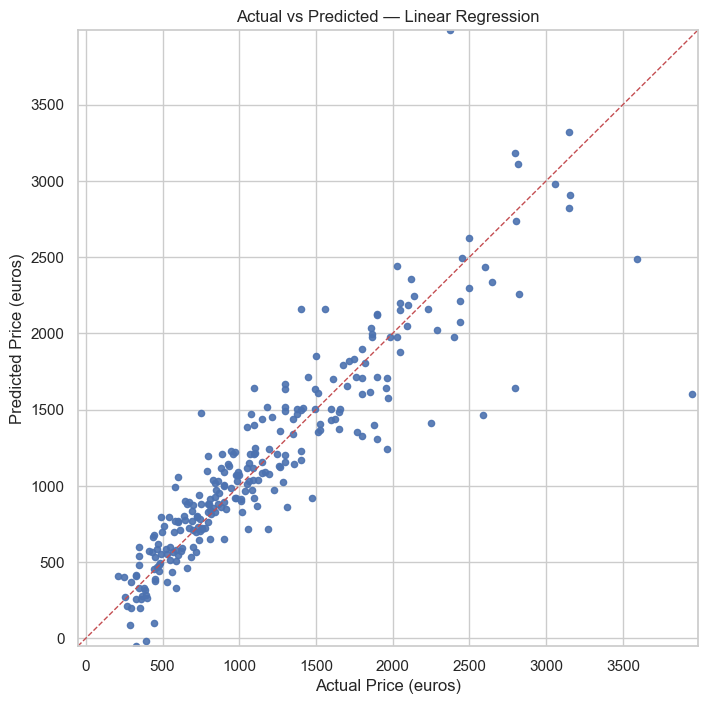

Plot saved to ../reports/figures/actual_vs_predicted_linear_regression.png


In [17]:
# Step 10 - Visualize Linear Regression results only
best_pred = y_pred_lr

plt.figure(figsize=(8,8))
plt.scatter(y_test, best_pred, alpha=0.9, s=20)
lims = [min(y_test.min(), best_pred.min()), max(y_test.max(), best_pred.max())]
plt.plot(lims, lims, 'r--', linewidth=1)  # identity line
plt.xlabel("Actual Price (euros)")
plt.ylabel("Predicted Price (euros)")
plt.title("Actual vs Predicted — Linear Regression")
plt.xlim(lims)
plt.ylim(lims)
plt.grid(True)
plt.savefig("../reports/figures/actual_vs_predicted_linear_regression.png", dpi=150)
plt.show()
print("Plot saved to ../reports/figures/actual_vs_predicted_linear_regression.png")

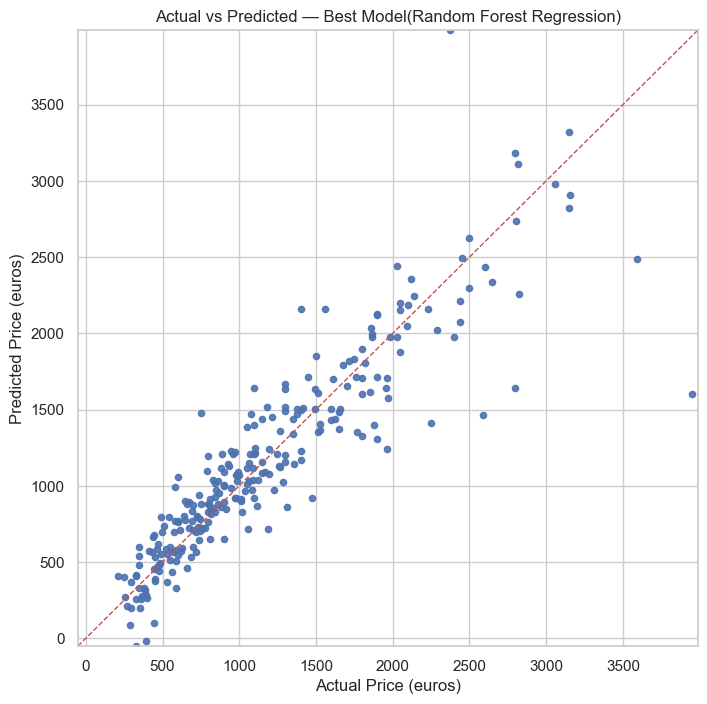

In [22]:
# Step 10 - Visualize best model results(For Random Forest)
best_model = rf if r2_rf >= r2_lr else lin_reg
best_pred_rf = y_pred_rf if best_model is rf else y_pred_lr

plt.figure(figsize=(8,8))
plt.scatter(y_test, best_pred, alpha=0.9, s=20)
limits = [min(y_test.min(), best_pred.min()), max(y_test.max(), best_pred.max())]
plt.plot(limits, limits, 'r--', linewidth=1)  # identity line
plt.xlabel("Actual Price (euros)")
plt.ylabel("Predicted Price (euros)")
plt.title("Actual vs Predicted — Best Model(Random Forest Regression)")
plt.xlim(limits)
plt.ylim(limits)
plt.grid(True)
plt.savefig("../reports/figures/actual_vs_predicted_best_model.png", dpi=150)
plt.show()

### Initial Model Training Results

We compared two models: Linear Regression and Random Forest.

- **Linear Regression** achieved an R² of 0.812, RMSE of €304.02, and MAE of €216.53.
- **Random Forest** achieved an R² of 0.858, RMSE of €264.62, and MAE of €176.32.

**Conclusion:** Random Forest performs better overall, explaining more of the variance in laptop prices and reducing prediction error by around €40 on average compared to Linear Regression. We selected Random Forest as the final model and saved it for deployment.


### Step 11 — Save the best model for deployment
- Simply save the model file to `../models` for use in Streamlit or inference.

In [ ]:
best_model_path = "../models/laptop_price_model.pkl"
joblib.dump(lin_reg, best_model_path)
print(f"Saved best model to {best_model_path}")
# If you trained linear regression and plan to use the scaler, scaler already saved earlier.

Saved best model to ../models/laptop_price_model.pkl


### Step 12 — Next steps (notes)
- If Random Forest is best, consider GridSearchCV / RandomizedSearchCV to tune hyperparameters.
- If deployment is required, create a small API or Streamlit app that loads `../models/laptop_price_model.pkl` and `../models/scaler.pkl`.
- Save feature list and preprocessing steps (so you apply exactly the same transforms at inference).

In [14]:
# Step 12 - Save feature list
feature_list_path = "../models/feature_names.pkl"
joblib.dump(X_train_encoded.columns.tolist(), feature_list_path)
print(f"Saved feature names to {feature_list_path}")


Saved feature names to ../models/feature_names.pkl
